In [25]:
import sys
sys.argv = [sys.argv[0]]

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import albumentations
import matplotlib.pyplot as plt
import random
import shutil


### Loading the data

Modify the annotations.csv to the correct format for YOLO

In [ ]:
def convert_annotations_to_yolo(row, img_width, img_height):
    x_start, y_start, x_end, y_end = row['x_start'], row['y_start'], row['x_end'], row['y_end']
    id = row['class_label']

    # YOLO has a different format for bounding box annotations
    x_center = ((x_start + x_end) / 2) / img_width
    y_center = ((y_start + y_end) / 2) / img_height
    width = (x_end - x_start) / img_width
    height = (y_end - y_start) / img_height

    return f"{id} {x_center} {y_center} {width} {height}"

# Original annotations
annotations = pd.read_csv('annotations.csv')

# Output folder to put the yolo labels into
output_dir = 'yolo_labels'
os.makedirs(output_dir, exist_ok=True)

for _, row in annotations.iterrows():
    img_path = row['image_path']
    image = cv2.imread(img_path)

    if image is None:
        print(f"Image not found: {img_path}")
        continue

    img_height, img_width = image.shape[:2]
    yolo_annotation = convert_annotations_to_yolo(row, img_width, img_height)

    txt_path = os.path.join(output_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
    with open(txt_path, 'w') as f:
        f.write(yolo_annotation + '\n')


Restructure the images folder to work with YOLO training

In [ ]:
image_dir = "images" # Current image dir
label_dir = "yolo_labels"  # Current label dir
output_dir = "dataset"  # THe new folder to save the dataset
ratios = {"train": 0.8, "val": 0.1, "test": 0.1}

# Create the directories
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels", split), exist_ok=True)

image_paths = []
for class_folder in os.listdir(image_dir):
    class_path = os.path.join(image_dir, class_folder)
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            image_paths.append(os.path.join(class_folder, image))

# Shuffle the images and then split by the correct ratios
random.shuffle(image_paths)
total = len(image_paths)
train_split = int(ratios["train"] * total)
val_split = int(ratios["val"] * total)

splits = {
    "train": image_paths[:train_split],
    "val": image_paths[train_split:train_split + val_split],
    "test": image_paths[train_split + val_split:]
}

for split, paths in splits.items():
    for path in paths:
        # Copy image to the correct folder
        src_image = os.path.join(image_dir, path)
        dst_image = os.path.join(output_dir, "images", split, os.path.basename(path))
        shutil.copyfile(src_image, dst_image)

        # Copy the label to the correct folder
        label_file = os.path.splitext(os.path.basename(path))[0] + ".txt"
        src_label = os.path.join(label_dir, label_file)
        dst_label = os.path.join(output_dir, "labels", split, label_file)
        if os.path.exists(src_label):
            shutil.copyfile(src_label, dst_label)

Dataset reorganized into dataset


In [ ]:
augmentations = albumentations.Compose([
    albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    albumentations.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5), # Rotation but don't wrap
    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, p=0.5), # Don't wrap again
    albumentations.GaussianBlur(blur_limit=(3, 5), p=0.4),
    albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4)
], bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def apply_augmentations(image, bboxes, class_labels):
    augmented = augmentations(image=image, bboxes=bboxes, class_labels=class_labels)
    return augmented['image'], augmented['bboxes'], augmented['class_labels']

images_to_augment = "dataset/images/train"
labels_to_augment = "dataset/labels/train"
augmented_dir_images = "augmented_dataset/images/train"
augmented_dir_labels = "augmented_dataset/labels/train"

os.makedirs(augmented_dir_images, exist_ok=True)
os.makedirs(augmented_dir_labels, exist_ok=True)

# Process each image
for image_file in os.listdir(images_to_augment):
    image_path = os.path.join(labels_to_augment, image_file)
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(labels_to_augment, label_file)

    if not os.path.exists(label_path):
        continue

    # Read image and label
    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    bboxes = []
    class_labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        x_start = (x_center - width / 2) * img_width
        y_start = (y_center - height / 2) * img_height
        x_end = (x_center + width / 2) * img_width
        y_end = (y_center + height / 2) * img_height
        bboxes.append([x_start, y_start, x_end, y_end])
        class_labels.append(class_id)

    try:
        # Apply the augmentations
        augmented_image, augmented_bboxes, augmented_classes = apply_augmentations(
            image, bboxes, class_labels)

        augmented_image_path = os.path.join(augmented_dir_images, image_file)
        cv2.imwrite(augmented_image_path, augmented_image)

        # Augment the label and bounding box and then save it
        augmented_label_path = os.path.join(augmented_dir_labels, label_file)
        with open(augmented_label_path, "w") as f:
            for bbox, class_id in zip(augmented_bboxes, augmented_classes):
                x_start, y_start, x_end, y_end = bbox
                x_center = (x_start + x_end) / 2 / img_width
                y_center = (y_start + y_end) / 2 / img_height
                width = (x_end - x_start) / img_width
                height = (y_end - y_start) / img_height
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    except Exception as e:
        print(f"Skipping augmentation {image_file}")

print(f"Saved to {augmented_dir_images} and {augmented_dir_labels}")


Skipping augmentation for IMG_5179.JPG due to invalid bounding boxes: x_max is less than or equal to x_min for bbox [0.8369709  0.24280754 0.0869709  0.7068452  1.        ].
Skipping augmentation for IMG_3047.jpg due to invalid bounding boxes: x_max is less than or equal to x_min for bbox [0.6554404  0.16645078 0.         0.5955311  1.        ].
Skipping augmentation for IMG_4894.JPG due to invalid bounding boxes: x_max is less than or equal to x_min for bbox [0.9424603  0.20833333 0.1332672  0.6706349  1.        ].
Skipping augmentation for IMG_2930.jpg due to invalid bounding boxes: x_max is less than or equal to x_min for bbox [0.6295337  0.25971502 0.         0.6207902  1.        ].
Skipping augmentation for IMG_2735.jpg due to invalid bounding boxes: x_max is less than or equal to x_min for bbox [0.83117443 0.4138601  0.01295337 0.9789508  1.        ].
Skipping augmentation for d53796be-4ea6-47f0-9bb1-070b8aaf825b.JPG due to invalid bounding boxes: x_max is less than or equal to x

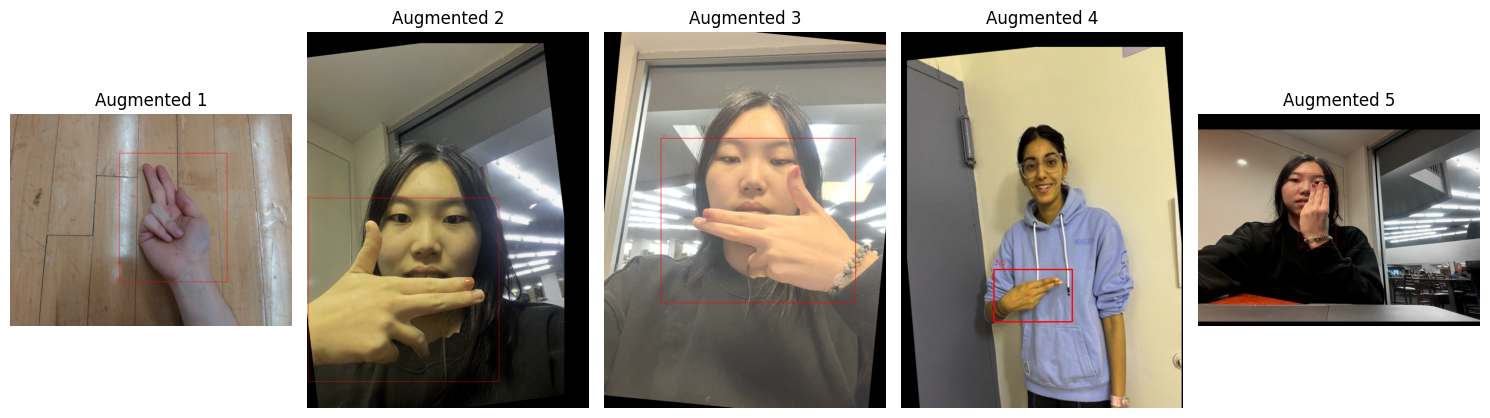

In [ ]:
augmentations = albumentations.Compose([
    albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    albumentations.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5), # Rotation but don't wrap
    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, p=0.5), # Don't wrap again
    albumentations.GaussianBlur(blur_limit=(3, 5), p=0.4),
    albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4)
], bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def show_augmented_images(images_dir, labels_dir, sample_size=5):
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    random_images = random.sample(image_files, sample_size)

    plt.figure(figsize=(15, 10))
    
    for idx, image_file in enumerate(random_images):
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, os.path.splitext(image_file)[0] + ".txt")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        # Get the bounding boxes and render them
        bboxes = []
        class_labels = []
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                
                # Reconvert YOLO format to x1, y1, x2, y2
                x_start = int((x_center - width / 2) * w)
                y_start = int((y_center - height / 2) * h)
                x_end = int((x_center + width / 2) * w)
                y_end = int((y_center + height / 2) * h)
                
                bboxes.append([x_start, y_start, x_end, y_end])
                class_labels.append(class_id)

        # Apply augmentations
        augmented = augmentations(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented["image"]
        aug_bboxes = augmented["bboxes"]
        aug_classes = augmented["class_labels"]

        # Put the bounding boxes back on the images
        for bbox, class_id in zip(aug_bboxes, aug_classes):
            x_start, y_start, x_end, y_end = map(int, bbox)
            cv2.rectangle(aug_image, (x_start, y_start), (x_end, y_end), (255, 0, 0), 2)
            cv2.putText(aug_image, str(class_id), (x_start, y_start - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Plot image
        plt.subplot(1, sample_size, idx + 1)
        plt.imshow(aug_image)
        plt.title(f"Augmented {idx+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

images_dir = "dataset/images/train"
labels_dir = "dataset/labels/train"

show_augmented_images(images_dir, labels_dir, sample_size=5)
